## MeanFlow 
Kaiming He and others have released a paper on flow based model where they are modeling average velocity instead of instantaneous velocity as we have seen in the previous flow implementation.

In [2]:
# Looad required libraries 

import torch 
import numpy as np
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

## Foundations - Gradients
Paper speaks about Jacobian vector product, while I would like you to refer to some good resources on internet for what directional derivatives means, I will still do my job here using a simple example ( u can watch many online videos with nice visualizations), consider an example $f(x)=x^2y$

Now the partial derivate of this function basically gives

$$
\nabla f = \begin{bmatrix} \frac{\partial f}{\partial x} \\ \frac{\partial f}{\partial y} \end{bmatrix}
$$

$$
\nabla f = \begin{bmatrix} 2xy \\ x^2 \end{bmatrix}
$$

Now the gradient is like a vector field as shown below




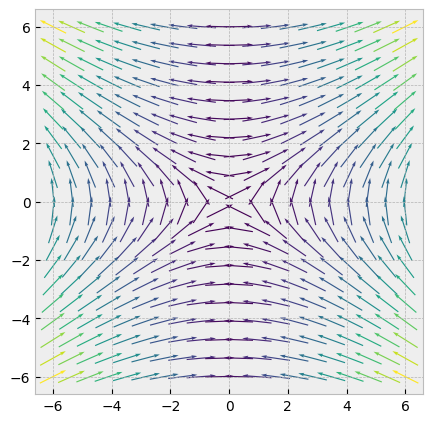

In [3]:
x = np.linspace(-6, 6, 20)
y = np.linspace(-6, 6, 20)
X, Y = np.meshgrid(x, y)

# Calculate vector components
# f(x, y) = [2xy, x^2]
U = 2*X*Y  # x-component: 2xy
V = X**2  # y-component: x^2
magnitude = np.sqrt(U**2 + V**2)

U_norm = U/magnitude
V_norm = V/magnitude

# Create the plot
plt.figure(figsize=(5, 5))

# Plot the vector field with color based on magnitude
plt.quiver(X, Y, U_norm, V_norm, magnitude, cmap='viridis', 
           pivot='mid', angles='xy', scale_units='xy', scale=1)
plt.show()

## Foundations Directional derivatives 
A small nudge in x and in y basically gives the rate of change in the function f(x,y), this is often represented in partial derivatives as [$\frac{df}{dx}$, $\frac{df}{dy}$] (shown above). Now from any point on the function there can be several unit vectors pointing in different directions, lets call this vector $\vec{v}$ and represented as $[a, b]$. Now as we move along this vector direction, a small nudge in x direction means its equivalent to $a*\nabla x f$ and small nudge in y direction means its equivalent to $b*\nabla y f$

the directional derivative is simply the dot product.
$$
D_{\vec{v}}f = \frac{df}{ds} = a \frac{\partial f}{\partial x} + b \frac{\partial f}{\partial y} = \nabla f \cdot \vec{v}
$$

Now lets calculate directional derivate of a function $f(x,y) = x^2y$ at (1,2) in the direction of (-1/$\sqrt{5}$, 2/$\sqrt{5}$)

$$
df = -1/\sqrt{5} * \frac{\partial f}{\partial x} + 2\sqrt{5} * \frac{\partial f}{\partial y}
$$

$$
\frac{\partial f}{\partial x} = 2xy = 2*1*2 = 4
$$

$$
\frac{\partial f}{\partial y} = x^2 = 1
$$

$$
df = \frac{-1}{\sqrt{5}} * 4 + \frac{2}{\sqrt{5}} * 1 = \frac{-2}{\sqrt{5}}
$$

In [4]:
-2/torch.sqrt(torch.tensor(5))

tensor(-0.8944)

## Jacobian vector product 
In pytorch calculating this directional derivative is called Jacobian vector product. we will do the above example using pytorch now.

In [5]:
point = torch.tensor([1.0, 2.0], requires_grad=True)
x, y = point[0], point[1]

# Define direction vector (not necessarily unit vector initially)
direction = torch.tensor([-1.0, 2.0])

# Normalize to make it a unit vector for proper directional derivative
unit_direction = direction / torch.norm(direction)
unit_direction


tensor([-0.4472,  0.8944])

In [6]:
def func_vector_input(inputs):
    x, y = inputs[0], inputs[1]
    return x**2 * y

In [7]:
func_output, directional_deriv_jvp = torch.autograd.functional.jvp(
    func_vector_input, 
    (point,), 
    (unit_direction,)
)
func_output, directional_deriv_jvp

(tensor(2.), tensor(-0.8944))

> the second term is the directional derivative of the function. 

> first term in the function output

we can see that both are same. we will now learn why this is important and how it is used in the paper.

## Paper 

we will start with instantenous change in velocity

$$
\frac{d}{dt}z_{t} = v(z_{t}, t)
$$

and 

$$
z_{t} = (1-t)x_{0} + t x_{1}
$$

$$
\frac{d}{dt}z_{t} = x_{1} - x_{0}
$$

here $x_{1}$ is $p_{data}$ and $x_{0}$ is $p_{noise}$ 


### MeanFlow 
instead of looking at instantenous change of velocity, in the paper they look at average velocity within a time period r to t. this is given as 

$$
u(z_{t}, r, t) = \frac{1}{t-r} \int_{r}^{t} v(z_{t}, \tau) d\tau
$$

becomes 
$$
(t-r) u(z_{t}, r, t) = \int_{r}^{t} v(z_{t}, \tau) d\tau
$$

differentiating both sides by dt 

$$
\frac{d}{dt} (t-r) u(z_{t}, r, t) = \frac{d}{dt} \int_{r}^{t} v(z_{t}, \tau) d\tau 
$$

$$
 u(z_{t}, r, t) + (t-r) \frac{d}{dt} u(z_{t}, r, t) = v(z_{t}, t)
$$

moving things from left to right, we have average velocity equals to instant velocity and time derivative.
$$
u(z_{t}, r, t) = v(z_{t}, t) - (t-r) \frac{d}{dt} u(z_{t}, r, t) 
$$

### computing time derivative 
using partial derivatives we can expand

$$
\frac{d}{dt} u(z_{t}, r, t)  = \frac{dz_{t}}{dt} \partial_{z}u + \frac{dr}{dt} \partial_{r}u + \frac{dt}{dt} \partial_{t}u
$$

this looks like dot product ($\frac{dz_{t}}{dt}$, $\frac{r}{dt}$, $\frac{dt}{dt}$) and ($\partial_{z}u$, $\partial_{r}u$, $\partial_{t}u$). ($\frac{dz_{t}}{dt}$, $\frac{r}{dt}$, $\frac{dt}{dt}$)  can be further be simplied as

$$
\frac{dz_{t}}{dt} = v(z_{t}, t)
$$

$$
 \frac{r}{dt} = 0
$$

$$
\frac{t}{dt} = 1
$$

so (v, 0, 1)

so the dot product between ($\partial_{z}u$, $\partial_{r}u$, $\partial_{t}u$) lets call this $\vec{J}$ and  ($\frac{dz_{t}}{dt}$ and (v($z_{t}$, t), 0, 1) $\vec{Q}$. 


so finally $u(z_{t}, r, t)$ becomes 

$$
u(z_{t}, r, t) = v(z_{t}, t) - (t-r) (\vec{J}.\vec{Q})
$$


$\vec{J}.\vec{Q}$ is obtained in pytorch using `torch.autograd.functional.jvp` which we will see in the next sections. 


Note that when t = r the average velocity just comes instantaneous velocity.





## MNIST

In [8]:
# Load MNIST data 

# Load MNIST data and resize it to 64x64
def load_mnist(bs=64):
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('data/', train=True, download=True,
                                    transform=torchvision.transforms.Compose([
                                        torchvision.transforms.Pad(2),
                                        torchvision.transforms.ToTensor(),
                                        torchvision.transforms.Normalize(0.5, 0.5),
                                    ])),
        batch_size=bs, shuffle=True)

    val_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('data/', train=False, download=True,
                                    transform=torchvision.transforms.Compose([
                                        torchvision.transforms.Pad(2),
                                        torchvision.transforms.ToTensor(),
                                        torchvision.transforms.Normalize(0.5, 0.5),
                                    ])),
        batch_size=bs, shuffle=False)
    return train_loader, val_loader

train_loader, val_loader = load_mnist(bs=64)

print(len(train_loader), len(val_loader))

imgs, labels = next(iter(val_loader))
imgs.shape

938 157


torch.Size([64, 1, 32, 32])

In [9]:
imgs, labels = next(iter(train_loader))
imgs.shape, labels.shape

(torch.Size([64, 1, 32, 32]), torch.Size([64]))

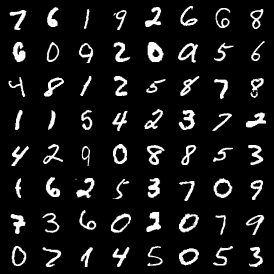

In [10]:
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(imgs, nrow=8, normalize=True))

In [76]:
time = torch.distributions.Normal(-0.4, 1)
rt = time.sample((10,2)).sort(dim=1).values
rt = torch.sigmoid(rt)
rt



tensor([[0.2020, 0.5384],
        [0.3344, 0.5198],
        [0.1382, 0.4042],
        [0.2740, 0.5551],
        [0.4417, 0.7930],
        [0.4168, 0.4902],
        [0.3992, 0.7372],
        [0.0755, 0.1888],
        [0.2487, 0.7476],
        [0.1635, 0.5199]])

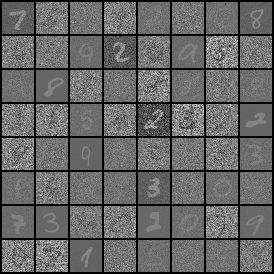

In [77]:
bs = imgs.shape[0]
rt = time.sample((bs,2)).sort(dim=1).values
noise = torch.randn_like(imgs)
t = rt[:, 1].unsqueeze(1).unsqueeze(1).unsqueeze(1)
xt = (1-t)*(noise) + t*imgs
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(xt, nrow=8, normalize=True))


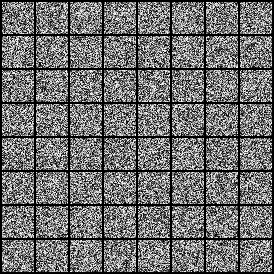

In [78]:
target = imgs - noise
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(target, nrow=8, normalize=False))

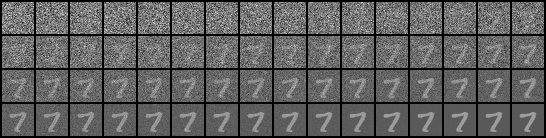

In [79]:
# lets also look how same image looks at different timesteps
simgs = imgs[0].unsqueeze(0).repeat(bs, 1, 1, 1)
bs = simgs.shape[0]
t = torch.linspace(0, 1, bs).unsqueeze(1).unsqueeze(1).unsqueeze(1)
noise = torch.randn_like(simgs)
sxt = (1-t)*noise + t*simgs
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(sxt, nrow=16, normalize=True))

## Network
we have two conditionals here r and t. in the paper they mentioned we can condition this as 
- r, t separately 
- t, t-r 
- t, r, t-r 
- t-r only 

> t, t-r got the best results. 


for imageNet they used DiT architecture but for CIFAR-10 they used U-Net. we cannot use U-Net from diffusers directly as it takes only one time conditioning and here we have to condition on two variables t and t-r. In the paper, they took positional embeddings of the time variables and then concatenated them before sending to the architecture. 

I have made these changes to diffusers UNet 2D using `multiple_time_embeddings`
- for both t and t-r get positional embeddings. 
- use linear layers to calculate their embeddings. 
- concat both of these.

In [61]:
from unet2d import UNet2DModel

device = "cuda"

model = UNet2DModel(
    sample_size=32,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    multiple_time_embeddings=True,
    block_out_channels=(64, 128, 256, 512),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
)
model.to(device)
print("model loaded")

model loaded


In [62]:
from diffusers.models.attention_processor import AttnProcessor


for blocks in model.down_blocks:
    if hasattr(blocks, "attentions"):
        for attn in blocks.attentions:
            attn.processor = AttnProcessor()

for blocks in model.up_blocks:
    if hasattr(blocks, "attentions"):
        for attn in blocks.attentions:
            attn.processor = AttnProcessor()

model.mid_block.attentions[0].processor = AttnProcessor()
print("processor set")

processor set


In [63]:
def load_model(device, channels=1):
    model = UNet2DModel(
        sample_size=32,
        in_channels=channels,
        out_channels=channels,
        layers_per_block=2,
        multiple_time_embeddings=True,
        block_out_channels=(64, 128, 256, 512),
        down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),
        up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
    )
    model.to(device)

    for blocks in model.down_blocks:
        if hasattr(blocks, "attentions"):
            for attn in blocks.attentions:
                attn.processor = AttnProcessor()

    for blocks in model.up_blocks:
        if hasattr(blocks, "attentions"):
            for attn in blocks.attentions:
                attn.processor = AttnProcessor()

    model.mid_block.attentions[0].processor = AttnProcessor()
    return model

In [64]:
count = 0
for name, param in model.named_parameters():
    count += param.numel()
count # this is a ~16 million parameters model


57833089

In [80]:
out = model(xt.to(device), (rt*1000).to(device))
out.shape, torch.nn.functional.mse_loss(out, target.to(device))

(torch.Size([64, 1, 32, 32]),
 tensor(2.0145, device='cuda:0', grad_fn=<MseLossBackward0>))

In [81]:
u, dudt = torch.autograd.functional.jvp(
    model, 
    (xt.to(device), (rt*1000).to(device)), 
    (target.to(device), torch.tensor([0, 1]).repeat(xt.shape[0], 1).to(device))
)
u.shape, dudt.shape

(torch.Size([64, 1, 32, 32]), torch.Size([64, 1, 32, 32]))

In [82]:
u_tgt = target.to(device) - (rt[:, 1] - rt[:, 0]).unsqueeze(1).unsqueeze(1).unsqueeze(1).to(device)*dudt
error = torch.nn.functional.mse_loss(u, u_tgt.detach())
error
# calculate the gradient of the error with respect to the model parameters

tensor(2.9475, device='cuda:0')

In [83]:
## Pseudo Huber loss 

# def adaptive_weighted_short(input, target, p=0.5, c=1e-3):
#     mse = torch.nn.functional.mse_loss(input, target, reduction='none')
#     return (mse / (mse + c)**p).mean()


def adaptive_l2_loss(error, gamma=0.5, c=1e-3):
    """
    Adaptive L2 loss: sg(w) * ||Δ||_2^2, where w = 1 / (||Δ||^2 + c)^p, p = 1 - γ
    Args:
        error: Tensor of shape (B, C, W, H)
        gamma: Power used in original ||Δ||^{2γ} loss
        c: Small constant for stability
    Returns:
        Scalar loss
    """
    delta_sq = torch.mean(error ** 2, dim=(1, 2, 3), keepdim=False)
    p = 1.0 - gamma
    w = 1.0 / (delta_sq + c).pow(p)
    loss = delta_sq  # ||Δ||^2
    return (w.detach() * loss).mean()


In [84]:
adaptive_l2_loss(u - u_tgt.detach())

tensor(1.6489, device='cuda:0')

In [85]:
rt.shape, torch.tensor([[0.0, 1.0]]).shape

(torch.Size([64, 2]), torch.Size([1, 2]))

## One step sampling

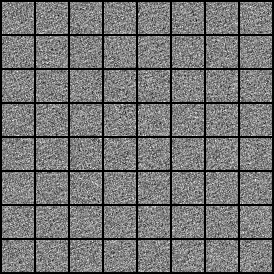

In [87]:
def one_step_sampling(model, bs, scale=1000):
    e = torch.randn(bs, 1, 32, 32).cuda()
    sample = model(e, torch.tensor([[0.0, 1.0*scale]]*bs).cuda())
    x = e +sample 
    return x 

x = one_step_sampling(model, 64)
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(x.detach().cpu(), nrow=8, normalize=True))

## Multistep sampling. 

In [88]:
r = torch.arange(0, 1000+(1000//200), 1000//200)
rt = torch.stack([r[:-1], r[1:]]).permute(1, 0)
rt.shape

torch.Size([200, 2])

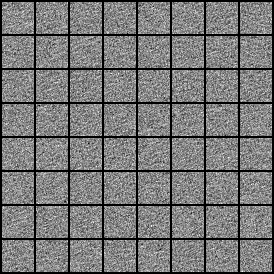

In [89]:
def multi_step_sampling(model, bs, n_steps, scale=1000):
    e = torch.randn(bs, 1, 32, 32).to(model.device)
    _scale = 1000
    r = torch.arange(0, _scale+(_scale//n_steps), _scale//n_steps).to(model.device)/_scale
    rt = torch.stack([r[:-1], r[1:]]).permute(1, 0)
    for i in range(n_steps):
        _rt = rt[i]
        r, t = _rt
        with torch.no_grad():
            sample = model(e, torch.tensor([[r*scale, t*scale]]*bs).to(model.device))
        e = e + (t-r)*sample 
    return e 

x = multi_step_sampling(model, 64, 10, scale=1)
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(x.detach().cpu(), nrow=8, normalize=True))

## Full training pipeline 

In the paper they found the following parameters to work and gave the best FID score.
- 25% of the training loop r is not equal to t. this means that it drops down to simple Flow matching 
- t and r comes from lognorm(-0.4, 1.0). In paper this is little confusion to me whether it is logit norm or LogNorm. I will go with logitnorm. 
- used Pseudo-Huber loss and the got the best FID score for p=1.5 
- jvp used is (v, 0, 1).
- instead of (r, t), (t, t-r) gave the best results though the changes are minimal. so we will continue using (r, t)
- CFG scale: we will skip this for now. 

In [91]:
norm = torch.distributions.Normal(loc=-0.4, scale=1)
rt = torch.sigmoid(norm.sample((bs,2))).sort(dim=1).values 
rt.shape

torch.Size([64, 2])

In [92]:
def sample_rt(bs, dist, p=0.25):
    rt1 = torch.sigmoid(dist.sample((int(bs*p),2))).sort(dim=1).values
    rt2 = torch.sigmoid(dist.sample((int(bs*(1-p)), )))
    rt2 = torch.stack([rt2, rt2]).permute(1, 0)
    rt = torch.cat([rt1, rt2], dim=0)
    #shuffle rows 
    rt = rt[torch.randperm(rt.shape[0])]
    return rt 

In [93]:
sample_rt(16, norm, 0.25)

tensor([[0.3157, 0.3157],
        [0.7901, 0.7901],
        [0.5152, 0.5152],
        [0.2720, 0.2720],
        [0.2594, 0.2594],
        [0.0741, 0.0741],
        [0.8345, 0.8345],
        [0.2541, 0.4402],
        [0.5417, 0.5417],
        [0.2506, 0.3092],
        [0.7346, 0.7346],
        [0.5648, 0.5996],
        [0.1702, 0.1702],
        [0.4761, 0.4761],
        [0.7012, 0.7012],
        [0.3742, 0.7059]])

In [96]:
# we will add EMA weights to the model. 
import copy

def exists(val):
    return val is not None

class EMA():
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
    def update_average(self, old, new):
        if not exists(old):
            return new
        return old * self.beta + (1 - self.beta) * new

ema = EMA(beta=0.99995)
ema_model = copy.deepcopy(model)

In [97]:
import fastcore.all as fc 
storage_path = fc.Path("mean_flow")
storage_path.mkdir(parents=True, exist_ok=True)

In [98]:
epochs = 100 
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-5)
train_loader, val_loader = load_mnist(bs=128)
total_steps = len(train_loader) * epochs
tdist = torch.distributions.Normal(-2, 2)
scale =1 

iter = 0 
train_loss = []

for epoch in range(epochs):
    model.train()
    epoch_loss = []
    with tqdm(train_loader, unit="batch") as tepoch:
        for batch in tepoch:
            optimizer.zero_grad()
            
            x1, _ = batch
            bs = x1.shape[0]
            x1 = x1.to(device)
            noise = torch.randn((bs, 1, 32, 32), device=device)
            target = x1 - noise 
            rt = sample_rt(bs, tdist, 0.75)
            t = rt[:, 1].unsqueeze(1).unsqueeze(1).unsqueeze(1).to(device)
            xt = t*x1 + (1-t)*noise

            u, dudt = torch.autograd.functional.jvp(
                model, 
                (xt.to(device), (rt*scale).to(device)), 
                (target.to(device), torch.tensor([0, 1]).repeat(bs, 1).to(device)),
                create_graph=True
            )
            u_tgt = target.to(device) - (rt[:, 1] - rt[:, 0]).unsqueeze(1).unsqueeze(1).unsqueeze(1).to(device)*dudt
            u_tgt_detached = u_tgt.detach()
            u_tgt_detached = torch.clamp(u_tgt_detached, target.min(), target.max())
            #loss = torch.nn.functional.mse_loss(u, u_tgt_detached)
            #loss = adaptive_weighted_short(u, u_tgt_detached, p=1.0)
            loss = adaptive_l2_loss(u - u_tgt_detached)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Add gradient clipping
            optimizer.step()

            #calculate loss 
            tepoch.set_postfix(loss=loss.item())
            epoch_loss.append(loss.item())
                    
            #update ema model 
            for current_params, ma_params in zip(model.parameters(), ema_model.parameters()):
                    old_weight, up_weight = ma_params.data, current_params.data
                    ma_params.data = ema.update_average(old_weight, up_weight)
    
    train_loss.extend(epoch_loss)
    store = {
         "ema_model": ema_model.state_dict(),
         "model": model.state_dict(),
         "train_loss": np.mean(epoch_loss)
    }
    torch.save(store, storage_path/f"ema_model_{epoch}_{np.mean(epoch_loss):3f}.pth")
    print(f"Epoch {epoch} completed: train loss {np.mean(epoch_loss)}")
    #TODO: calculate some metric between generated images and original images

    ema_model.eval()
    out= one_step_sampling(ema_model, 64, scale=scale)
    img = torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(out.cpu(), nrow=8, normalize=True))
    img.save(storage_path/f"generated_images_one_step_{epoch}.png")

    out= multi_step_sampling(ema_model, 64, 20, scale=scale)
    img = torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(out.cpu(), nrow=8, normalize=True))
    img.save(storage_path/f"generated_images_multi_step_{epoch}.png")
    torch.cuda.empty_cache()
        
    

100%|██████████| 469/469 [01:14<00:00,  6.29batch/s, loss=0.512]


Epoch 0 completed: train loss 0.5836178415746831


100%|██████████| 469/469 [01:14<00:00,  6.33batch/s, loss=0.472]


Epoch 1 completed: train loss 0.5259268996812133


100%|██████████| 469/469 [01:14<00:00,  6.33batch/s, loss=0.504]


Epoch 2 completed: train loss 0.5094625178430634


100%|██████████| 469/469 [01:13<00:00,  6.35batch/s, loss=0.504]


Epoch 3 completed: train loss 0.5053190253436692


100%|██████████| 469/469 [01:13<00:00,  6.35batch/s, loss=0.463]


Epoch 4 completed: train loss 0.4984045190089293


100%|██████████| 469/469 [01:13<00:00,  6.37batch/s, loss=0.46] 


Epoch 5 completed: train loss 0.49528144474731073


100%|██████████| 469/469 [01:13<00:00,  6.34batch/s, loss=0.459]


Epoch 6 completed: train loss 0.49368496915933163


100%|██████████| 469/469 [01:13<00:00,  6.34batch/s, loss=0.541]


Epoch 7 completed: train loss 0.49334923977028333


100%|██████████| 469/469 [01:13<00:00,  6.35batch/s, loss=0.486]


Epoch 8 completed: train loss 0.4903151251868144


100%|██████████| 469/469 [01:14<00:00,  6.31batch/s, loss=0.528]


Epoch 9 completed: train loss 0.48849954546641694


100%|██████████| 469/469 [01:14<00:00,  6.29batch/s, loss=0.551]


Epoch 10 completed: train loss 0.4883938098767165


100%|██████████| 469/469 [01:14<00:00,  6.30batch/s, loss=0.477]


Epoch 11 completed: train loss 0.48671856344635805


100%|██████████| 469/469 [01:14<00:00,  6.32batch/s, loss=0.516]


Epoch 12 completed: train loss 0.48723298743335425


100%|██████████| 469/469 [01:14<00:00,  6.31batch/s, loss=0.47] 


Epoch 13 completed: train loss 0.48376516136787595


100%|██████████| 469/469 [01:14<00:00,  6.30batch/s, loss=0.486]


Epoch 14 completed: train loss 0.4832304215380378


100%|██████████| 469/469 [01:15<00:00,  6.25batch/s, loss=0.475]


Epoch 15 completed: train loss 0.4851866979588832


100%|██████████| 469/469 [01:15<00:00,  6.21batch/s, loss=0.487]


Epoch 16 completed: train loss 0.4830796867291302


100%|██████████| 469/469 [01:14<00:00,  6.29batch/s, loss=0.468]


Epoch 17 completed: train loss 0.4829001507398162


100%|██████████| 469/469 [01:14<00:00,  6.29batch/s, loss=0.498]


Epoch 18 completed: train loss 0.4819996507564333


100%|██████████| 469/469 [01:14<00:00,  6.30batch/s, loss=0.485]


Epoch 19 completed: train loss 0.48375830136890857


100%|██████████| 469/469 [01:14<00:00,  6.30batch/s, loss=0.487]


Epoch 20 completed: train loss 0.4804685966038246


100%|██████████| 469/469 [01:14<00:00,  6.30batch/s, loss=0.495]


Epoch 21 completed: train loss 0.4812948478183258


100%|██████████| 469/469 [01:14<00:00,  6.30batch/s, loss=0.49] 


Epoch 22 completed: train loss 0.4810054624385671


100%|██████████| 469/469 [01:15<00:00,  6.20batch/s, loss=0.463]


Epoch 23 completed: train loss 0.4799938471332542


100%|██████████| 469/469 [01:14<00:00,  6.28batch/s, loss=0.451]


Epoch 24 completed: train loss 0.4817024041086372


100%|██████████| 469/469 [01:14<00:00,  6.30batch/s, loss=0.464]


Epoch 25 completed: train loss 0.4796322183822518


100%|██████████| 469/469 [01:14<00:00,  6.31batch/s, loss=0.479]


Epoch 26 completed: train loss 0.4781486761849572


100%|██████████| 469/469 [01:14<00:00,  6.29batch/s, loss=0.576]


Epoch 27 completed: train loss 0.4812118380562837


100%|██████████| 469/469 [01:14<00:00,  6.27batch/s, loss=0.476]


Epoch 28 completed: train loss 0.478538684626378


100%|██████████| 469/469 [01:14<00:00,  6.28batch/s, loss=0.486]


Epoch 29 completed: train loss 0.47648913411697597


100%|██████████| 469/469 [01:14<00:00,  6.30batch/s, loss=0.463]


Epoch 30 completed: train loss 0.4790846702259487


100%|██████████| 469/469 [01:14<00:00,  6.28batch/s, loss=0.478]


Epoch 31 completed: train loss 0.4777735346543001


100%|██████████| 469/469 [01:15<00:00,  6.18batch/s, loss=0.443]


Epoch 32 completed: train loss 0.4799408233369083


100%|██████████| 469/469 [01:17<00:00,  6.08batch/s, loss=0.464]


Epoch 33 completed: train loss 0.47865703066528986


100%|██████████| 469/469 [01:15<00:00,  6.23batch/s, loss=0.463]


Epoch 34 completed: train loss 0.478738063179862


100%|██████████| 469/469 [01:15<00:00,  6.25batch/s, loss=0.48] 


Epoch 35 completed: train loss 0.47746119424224154


100%|██████████| 469/469 [01:16<00:00,  6.17batch/s, loss=0.452]


Epoch 36 completed: train loss 0.47806513277706564


100%|██████████| 469/469 [01:15<00:00,  6.18batch/s, loss=0.508]


Epoch 37 completed: train loss 0.47807535637162135


100%|██████████| 469/469 [01:16<00:00,  6.16batch/s, loss=0.488]


Epoch 38 completed: train loss 0.4785476249418279


100%|██████████| 469/469 [01:14<00:00,  6.29batch/s, loss=0.474]


Epoch 39 completed: train loss 0.4777496244226183


100%|██████████| 469/469 [01:14<00:00,  6.26batch/s, loss=0.458]


Epoch 40 completed: train loss 0.47616668912901805


100%|██████████| 469/469 [01:14<00:00,  6.30batch/s, loss=0.474]


Epoch 41 completed: train loss 0.4761198205607278


100%|██████████| 469/469 [01:14<00:00,  6.28batch/s, loss=0.448]


Epoch 42 completed: train loss 0.4750500856432071


100%|██████████| 469/469 [01:15<00:00,  6.21batch/s, loss=0.505]


Epoch 43 completed: train loss 0.47499406369510233


100%|██████████| 469/469 [01:15<00:00,  6.24batch/s, loss=0.432]


Epoch 44 completed: train loss 0.47555405162036546


100%|██████████| 469/469 [01:14<00:00,  6.30batch/s, loss=0.497]


Epoch 45 completed: train loss 0.4764982222366943


100%|██████████| 469/469 [01:15<00:00,  6.23batch/s, loss=0.481]


Epoch 46 completed: train loss 0.47560210147900367


100%|██████████| 469/469 [01:14<00:00,  6.28batch/s, loss=0.503]


Epoch 47 completed: train loss 0.4761475629643845


100%|██████████| 469/469 [01:14<00:00,  6.30batch/s, loss=0.473]


Epoch 48 completed: train loss 0.4744745045582623


100%|██████████| 469/469 [01:14<00:00,  6.27batch/s, loss=0.497]


Epoch 49 completed: train loss 0.47568427455196505


100%|██████████| 469/469 [01:14<00:00,  6.29batch/s, loss=0.5]  


Epoch 50 completed: train loss 0.47622223589211893


100%|██████████| 469/469 [01:15<00:00,  6.20batch/s, loss=0.502]


Epoch 51 completed: train loss 0.47585404465701786


100%|██████████| 469/469 [01:14<00:00,  6.28batch/s, loss=0.473]


Epoch 52 completed: train loss 0.47422924536123456


100%|██████████| 469/469 [01:14<00:00,  6.29batch/s, loss=0.489]


Epoch 53 completed: train loss 0.4744540721749954


100%|██████████| 469/469 [01:14<00:00,  6.27batch/s, loss=0.502]


Epoch 54 completed: train loss 0.4741474912364854


100%|██████████| 469/469 [01:14<00:00,  6.30batch/s, loss=0.459]


Epoch 55 completed: train loss 0.47232792238945137


100%|██████████| 469/469 [01:14<00:00,  6.29batch/s, loss=0.446]


Epoch 56 completed: train loss 0.4746722360409653


100%|██████████| 469/469 [01:14<00:00,  6.27batch/s, loss=0.474]


Epoch 57 completed: train loss 0.4741628902044886


100%|██████████| 469/469 [01:14<00:00,  6.28batch/s, loss=0.486]


Epoch 58 completed: train loss 0.47465058710020996


100%|██████████| 469/469 [01:14<00:00,  6.26batch/s, loss=0.51] 


Epoch 59 completed: train loss 0.47579454886379524


100%|██████████| 469/469 [01:14<00:00,  6.28batch/s, loss=0.458]


Epoch 60 completed: train loss 0.47466023854101136


100%|██████████| 469/469 [01:14<00:00,  6.27batch/s, loss=0.496]


Epoch 61 completed: train loss 0.47287954221656325


100%|██████████| 469/469 [01:14<00:00,  6.28batch/s, loss=0.47] 


Epoch 62 completed: train loss 0.4745973320658019


100%|██████████| 469/469 [01:14<00:00,  6.29batch/s, loss=0.491]


Epoch 63 completed: train loss 0.47311668933581696


100%|██████████| 469/469 [01:14<00:00,  6.28batch/s, loss=0.482]


Epoch 64 completed: train loss 0.4718548652332729


100%|██████████| 469/469 [01:14<00:00,  6.27batch/s, loss=0.478]


Epoch 65 completed: train loss 0.47345209617350403


100%|██████████| 469/469 [01:14<00:00,  6.27batch/s, loss=0.45] 


Epoch 66 completed: train loss 0.47352185019297893


100%|██████████| 469/469 [01:15<00:00,  6.25batch/s, loss=0.454]


Epoch 67 completed: train loss 0.4721498954524872


100%|██████████| 469/469 [01:14<00:00,  6.27batch/s, loss=0.44] 


Epoch 68 completed: train loss 0.4741069096237866


100%|██████████| 469/469 [01:15<00:00,  6.25batch/s, loss=0.437]


Epoch 69 completed: train loss 0.47337358840493


100%|██████████| 469/469 [01:15<00:00,  6.23batch/s, loss=0.455]


Epoch 70 completed: train loss 0.4743850657553561


100%|██████████| 469/469 [01:15<00:00,  6.25batch/s, loss=0.444]


Epoch 71 completed: train loss 0.4710092521679681


100%|██████████| 469/469 [01:14<00:00,  6.26batch/s, loss=0.476]


Epoch 72 completed: train loss 0.47196412366082163


100%|██████████| 469/469 [01:14<00:00,  6.28batch/s, loss=0.51] 


Epoch 73 completed: train loss 0.4734851726845129


100%|██████████| 469/469 [01:14<00:00,  6.28batch/s, loss=0.49] 


Epoch 74 completed: train loss 0.4723147427095279


100%|██████████| 469/469 [01:14<00:00,  6.26batch/s, loss=0.449]


Epoch 75 completed: train loss 0.47189823981287127


100%|██████████| 469/469 [01:15<00:00,  6.23batch/s, loss=0.508]


Epoch 76 completed: train loss 0.4745215827595196


100%|██████████| 469/469 [01:15<00:00,  6.21batch/s, loss=0.469]


Epoch 77 completed: train loss 0.47202496379931597


100%|██████████| 469/469 [01:15<00:00,  6.25batch/s, loss=0.447]


Epoch 78 completed: train loss 0.47299112268348237


100%|██████████| 469/469 [01:15<00:00,  6.25batch/s, loss=0.484]


Epoch 79 completed: train loss 0.473785281435513


100%|██████████| 469/469 [01:14<00:00,  6.28batch/s, loss=0.474]


Epoch 80 completed: train loss 0.47297162974058693


100%|██████████| 469/469 [01:14<00:00,  6.30batch/s, loss=0.446]


Epoch 81 completed: train loss 0.47231896243878263


100%|██████████| 469/469 [01:14<00:00,  6.29batch/s, loss=0.441]


Epoch 82 completed: train loss 0.4733201633257144


100%|██████████| 469/469 [01:15<00:00,  6.25batch/s, loss=0.493]


Epoch 83 completed: train loss 0.4715733035668127


100%|██████████| 469/469 [01:14<00:00,  6.28batch/s, loss=0.452]


Epoch 84 completed: train loss 0.4700872486334111


100%|██████████| 469/469 [01:14<00:00,  6.29batch/s, loss=0.462]


Epoch 85 completed: train loss 0.4720060881902414


100%|██████████| 469/469 [01:14<00:00,  6.28batch/s, loss=0.456]


Epoch 86 completed: train loss 0.47058340608438193


100%|██████████| 469/469 [01:14<00:00,  6.26batch/s, loss=0.459]


Epoch 87 completed: train loss 0.47214089661264724


100%|██████████| 469/469 [01:14<00:00,  6.26batch/s, loss=0.468]


Epoch 88 completed: train loss 0.4719091250316929


100%|██████████| 469/469 [01:14<00:00,  6.26batch/s, loss=0.453]


Epoch 89 completed: train loss 0.4725163420761572


100%|██████████| 469/469 [01:14<00:00,  6.27batch/s, loss=0.451]


Epoch 90 completed: train loss 0.4710133338152473


100%|██████████| 469/469 [01:14<00:00,  6.30batch/s, loss=0.491]


Epoch 91 completed: train loss 0.471910667063585


100%|██████████| 469/469 [01:14<00:00,  6.32batch/s, loss=0.472]


Epoch 92 completed: train loss 0.47166704292744716


100%|██████████| 469/469 [01:14<00:00,  6.32batch/s, loss=0.454]


Epoch 93 completed: train loss 0.4719299990485218


100%|██████████| 469/469 [01:14<00:00,  6.32batch/s, loss=0.481]


Epoch 94 completed: train loss 0.4725284275851016


100%|██████████| 469/469 [01:14<00:00,  6.30batch/s, loss=0.487]


Epoch 95 completed: train loss 0.4709103416913608


100%|██████████| 469/469 [01:14<00:00,  6.31batch/s, loss=0.455]


Epoch 96 completed: train loss 0.4728258418630181


100%|██████████| 469/469 [01:14<00:00,  6.29batch/s, loss=0.446]


Epoch 97 completed: train loss 0.47166328751710435


100%|██████████| 469/469 [01:14<00:00,  6.31batch/s, loss=0.478]


Epoch 98 completed: train loss 0.47201815705055367


100%|██████████| 469/469 [01:14<00:00,  6.32batch/s, loss=0.464]


Epoch 99 completed: train loss 0.4718866437228758


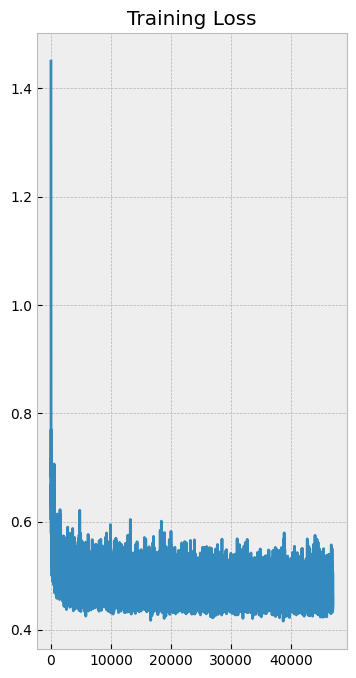

In [99]:
plt.figure(figsize=(4, 8))
plt.plot(train_loss)
plt.title("Training Loss")
plt.show()

## inference 

In [100]:
model = load_model(device, channels=1)
weights = torch.load("mean_flow/ema_model_99_0.471887.pth", weights_only=False)
model.load_state_dict(weights["ema_model"])
model.eval()
print("loaded weights and set in eval mode")

loaded weights and set in eval mode


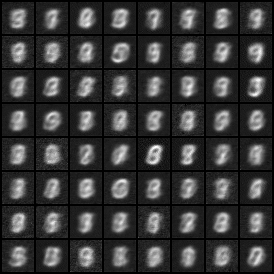

In [103]:
bs = 64
scale = 1
e = torch.randn(bs, 1, 32, 32).cuda()
sample = model(e, torch.tensor([[0.0, 1.0*scale]]*bs).cuda())
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(e+sample, nrow=8, normalize=True))